In [1]:
%pylab inline
import pandas as pd
import os

# Just use 1 GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import pandas as pd
from pywsi.io import WSIReader
from pywsi.morphology import TissuePatch
from matplotlib.patches import Polygon

from shapely.geometry import Point as shapelyPoint
from shapely.geometry import box as shapelyRectangle

from pywsi.io.operations import get_annotation_bounding_boxes, get_annotation_polygons, translate_and_scale_object
from pywsi.io.operations import translate_and_scale_polygon
from openslide.deepzoom import DeepZoomGenerator

import os
import glob
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray, gray2rgb
from shapely.geometry import Polygon as shapelyPolygon
import openslide
from joblib import Parallel, delayed

from tqdm import tqdm_notebook, tqdm
import cv2

from pywsi.io.operations import get_annotation_bounding_boxes, get_annotation_polygons, \
    poly2mask, translate_and_scale_polygon, read_as_rgb

from pywsi.morphology.patch_extractor import TissuePatch
from pywsi.morphology.mask import mpl_polygon_to_shapely_scaled, get_common_interior_polygons

from keras.models import Sequential
from keras.layers import Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit
from keras.callbacks import ModelCheckpoint

from pywsi.io.tiling import generate_tiles, get_all_patches_from_slide
import matplotlib.gridspec as gridspec
from sklearn.metrics import confusion_matrix
from tqdm import tqdm_notebook
from matplotlib import cm
from multiprocessing import Pool

NUM_CLASSES = 2 # not_tumor, tumor
BATCH_SIZE = 32

Populating the interactive namespace from numpy and matplotlib


/home/saket/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/saket/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/saket/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/home/saket/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/saket/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(256, 256, 3)))
model.add(Convolution2D(100, (5, 5), strides=(2, 2), activation='elu', padding='same'))
model.add(MaxPooling2D())
model.add(Convolution2D(200, (5, 5), strides=(2, 2), activation='elu', padding='same'))
model.add(MaxPooling2D())
model.add(Convolution2D(300, (3, 3), activation='elu', padding='same'))
model.add(Convolution2D(400, (3, 3), activation='elu',  padding='same'))
model.add(Dropout(0.1))
model.add(Convolution2D(400, (3, 3), activation='elu',  padding='same'))
model.add(Convolution2D(300, (3, 3), activation='elu',  padding='same'))
model.add(Dropout(0.1))
model.add(Convolution2D(2, (1, 1))) # this is called upscore layer for some reason?
model.add(Conv2DTranspose(2, (31, 31), strides=(16, 16), activation='softmax', padding='same'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [3]:
model.load_weights('weights-improvement-12-0.98.hdf')

In [4]:
def predict_from_model(patch, model):
    """Predict which pixels are tumor.
    
    input: patch: 256x256x3, rgb image
    input: model: keras model
    output: prediction: 256x256x1, per-pixel tumor probability
    """
    
    prediction = model.predict(patch.reshape(1, 256, 256, 3))
    prediction = prediction[:, :, :, 1].reshape(256, 256)
    return prediction


In [5]:
def plot_blend(patch, prediction, ax, alpha=0.75):
    """alpha blend patch and prediction.
    https://matplotlib.org/examples/pylab_examples/layer_images.html
    
    input: patch: 256x256x3, rgb image
    input: prediction: 256x256x1, per-pixel tumor probability
    input: ax: maplotlib Axes object
    input: alpha: alpha blend
    """
    
    dx, dy = 0.05, 0.05
    x = np.arange(0, patch.shape[1] - 1, dx)
    y = np.arange(0, patch.shape[0] - 1, dy)
    xmin, xmax, ymin, ymax = np.amin(x), np.amax(x), np.amin(y), np.amax(y)
    extent = xmin, xmax, ymin, ymax

    # fig = plt.figure(frameon=False, figsize=(10, 5))
    Z1 = rgb2gray(patch)
    Z2 = prediction

    im1 = ax.imshow(Z1, cmap='gray', extent=extent)
    im2 = ax.imshow(Z2, cmap='coolwarm', alpha=alpha, vmin=0.0, vmax=1.0,
                     extent=extent)
    ax.axis('off');

def plot_patch_with_pred(patch, truth, prediction, title_str='', alpha=0.6):
    """
    input: patch: 256x256x3, rgb image
    input: truth: 256x256x2, onehot output classes (not_tumor, tumor)
    input: prediction: 256x256x1, per-pixel tumor probability
    """
    gs = gridspec.GridSpec(2, 4, width_ratios=[10, 10, 19, 1])
    ax0 = plt.subplot(gs[0, 0])
    ax1 = plt.subplot(gs[0, 1])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[1, 1])
    ax4 = plt.subplot(gs[:, 2])
    axc = plt.subplot(gs[:, 3])

    ax0.imshow(patch);
    ax0.set_title('Original')
    
    ax1.imshow(truth.argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    ax1.set_title('Truth mask (white=tumor, black=not_tumor)')
    
    p = ax2.imshow(prediction, cmap='coolwarm', vmin=0, vmax=1);
    ax2.set_title('Prediction heatmap')

    ax3.imshow((prediction > 0.5).astype(np.int), cmap='gray', vmin=0, vmax=1);
    ax3.set_title('Prediction mask (white=tumor, black=not_tumor)')
    
    plot_blend(patch, prediction, ax4, alpha)
    ax4.set_title('Original+Prediction blend')
    
    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    fig.suptitle(title_str)
    fig.colorbar(p, cax=axc, orientation="vertical")
    axc.set_title('Probability pixel is tumor')
    
def predict_batch_from_model(patches, model):
    """Predict which pixels are tumor.
    
    input: patch: `batch_size`x256x256x3, rgb image
    input: model: keras model
    output: prediction: 256x256x1, per-pixel tumor probability
    """
    predictions = model.predict(patches)
    predictions = predictions[:, :, :, 1]
    return predictions

In [6]:
tumor_df = pd.read_table('/Z/personal-folders/interns/saket/histopath_data/patches_dataframe/training/tumor/master_df.tsv')
tumor_076 = tumor_df[tumor_df.uid=='tumor_076']
tumor_082 = tumor_df[tumor_df.uid=='tumor_082']
tumor_002 = tumor_df[tumor_df.uid=='tumor_002']

In [7]:
tumor_002.tile_loc = [eval(x) for x in tumor_002.tile_loc]

/home/saket/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [43]:
tumor_002

,is_tissue,is_tumor,uid,slide_path,json_filepath,tile_loc
23856,True,False,tumor_002,/Z/personal-folders/interns/saket/histopath_da...,/Z/personal-folders/interns/saket/histopath_da...,"(11, 233)"
23857,True,False,tumor_002,/Z/personal-folders/interns/saket/histopath_da...,/Z/personal-folders/interns/saket/histopath_da...,"(12, 233)"
23858,True,False,tumor_002,/Z/personal-folders/interns/saket/histopath_da...,/Z/personal-folders/interns/saket/histopath_da...,"(14, 234)"
23859,True,False,tumor_002,/Z/personal-folders/interns/saket/histopath_da...,/Z/personal-folders/interns/saket/histopath_da...,"(24, 272)"
23860,True,False,tumor_002,/Z/personal-folders/interns/saket/histopath_da...,/Z/personal-folders/interns/saket/histopath_da...,"(29, 32)"
23861,True,False,tumor_002,/Z/personal-folders/interns/saket/histopath_da...,/Z/personal-folders/interns/saket/histopath_da...,"(30, 32)"
23862,True,False,tumor_002,/Z/personal-folders/interns/saket/histopath_da...,/Z/personal-folders/interns/saket/histopath_da...,"(31, 32)"
23863,True,False,tumor_002,/Z/personal-folders/interns/saket/histopath_da...,/Z/personal-folders/interns/saket/histopath_da...,"(31, 64)"
23864,True,False,tumor_002,/Z/personal-folders/interns/saket/histopath_da...,/Z/personal-folders/interns/saket/histopath_da...,"(32, 18)"
23865,True,False,tumor_002,/Z/personal-folders/interns/saket/histopath_da...,/Z/personal-folders/interns/saket/histopath_da...,"(32, 28)"


In [86]:
sample_gen = generate_tiles(tumor_002.sample(32, random_state=4), 32, shuffle=True)

example_X, example_y  = next(sample_gen)

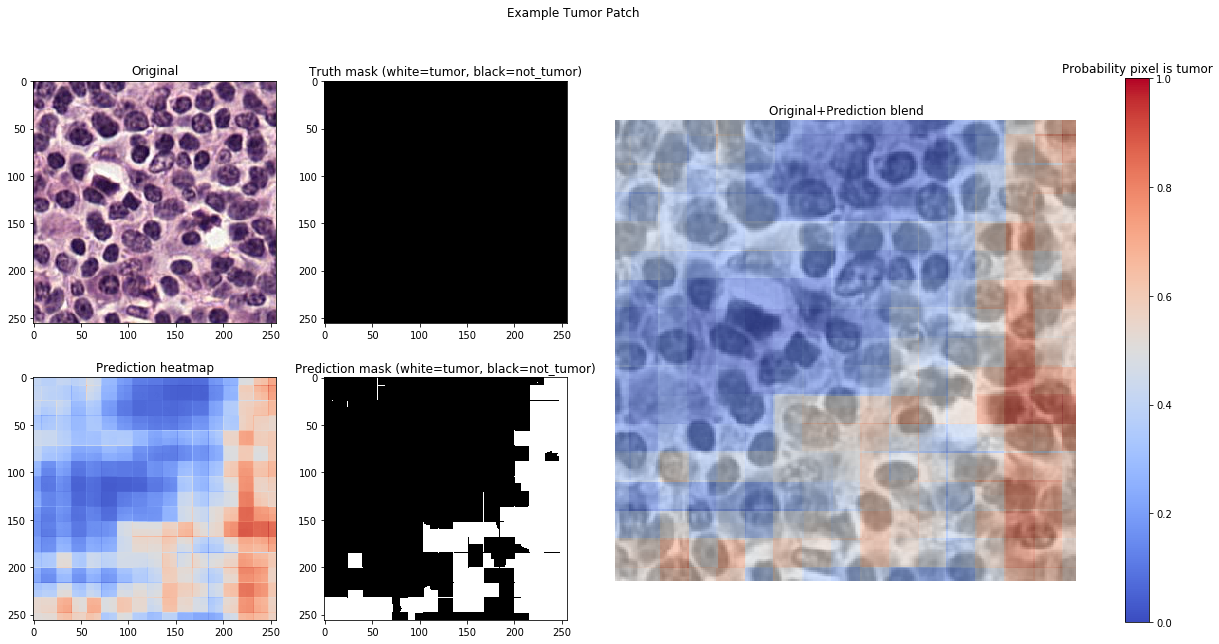

In [87]:
example_patch = example_X[-9]
example_truth = example_y[-9]

prediction = predict_from_model(example_patch, model)
fig = plt.figure(figsize=(10,10))
plot_patch_with_pred(example_patch, example_truth, prediction, title_str='Example Tumor Patch')
fig.savefig('plots_exploratory_analysis/blended_output.pdf')

# Generate entire tumor pics

In [15]:
output_dir = '/Z/personal-folders/interns/saket/histopath_data/prediction_heatmaps/tumor_038/'
os.makedirs(output_dir, exist_ok=True)

alpha = 0.5
slide_path = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16/training/tumor/tumor_038.tif'
json_filepath = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16/training/lesion_annotations_json/tumor_038.json'
all_samples = get_all_patches_from_slide(slide_path, json_filepath, False, 256)
slide = WSIReader(slide_path, 40)

n_samples = len(all_samples)
n_cols = int(slide.dimensions[0] / 256)
n_rows = int(slide.dimensions[1] / 256)
#assert n_cols * n_rows == n_samples

thumbnail = slide.get_thumbnail((n_cols, n_rows))
thumbnail = np.array(thumbnail)

# batch_size = n_cols
batch_size = 32
output_thumbnail_preds = list()

from joblib import Parallel, delayed

#Parallel(n_jobs=16)(   
def process_batch(args):
    idx, batch_samples, X = args
    png_fnames = batch_samples.tile_loc.apply(lambda coord: os.path.join(output_dir,
                                                                         '{}_{}.png'.format(coord[1], coord[0])))
    output_thumbnail_pred = None
    
    if batch_samples.is_tissue.nunique() == 1 and batch_samples.iloc[0].is_tissue == False:
        # all patches in this row do not have tissue, skip them all
        output_thumbnail_pred = np.zeros(batch_size, dtype=np.float32)
        
        # output pngs
        for i, png_fname in enumerate(png_fnames):
            plt.imsave(png_fname, X[i])
    else:
        # make predictions
        preds = predict_batch_from_model(X, model)
        output_thumbnail_pred = preds.mean(axis=(1,2))
        
        # overlay preds
        # save blended imgs
        
        for i, png_fname in enumerate(png_fnames):
            pred_i = preds[i]
            X_i = X[i]
            #output_img = rgb2gray(X_i)
            #output_img2 = gray2rgb(output_img.copy())

            #overlay = np.uint8(cm.viridis(pred_i) * 255)[:,:,:3]
            #blended = overlay*alpha + output_img2 *(1-alpha) +  0
            output_img = cv2.cvtColor(X_i, cv2.COLOR_RGB2GRAY)
            output_img2 = cv2.cvtColor(output_img.copy(), cv2.COLOR_GRAY2RGB)

            overlay = np.uint8(cm.viridis(pred_i) * 255)[:,:,:3]
            blended = cv2.addWeighted(overlay, alpha, output_img2, 1-alpha, 0, output_img)
            #blended = overlay*alpha + output_img2 *(1-alpha) +  0
            #blended = np.clip(blended, 0, 255)
            plt.imsave(png_fname, blended)
    return idx, output_thumbnail_pred

all_batch_samples = []
for offset in tqdm(list(range(0, n_samples, batch_size))):
    all_batch_samples.append(all_samples.iloc[offset:offset+batch_size])

total = len(list(range(0, n_samples, batch_size)))


100%|██████████| 10314/10314 [00:04<00:00, 2390.75it/s]


In [ ]:
output_thumbnail_preds = []
output_thumbnail_idx = []
with Pool(processes=32) as p:
    with tqdm(total=total) as pbar:    
    #output_thumbnail_pred = list(tqdm_notebook(p.imap(process_batch, all_batch_samples), total=total))
        
        results = p.imap_unordered(process_batch, samples)
        for idx, result in results:
            output_thumbnail_preds.append(result)
            output_thumbnail_idx.append(idx)
            pbar.update()
        #for i, output_thumbnail_pred in enumerate(p.map(process_batch, all_batch_samples)):
        #    output_thumbnail_preds.append(output_thumbnail_pred)
        #    pbar.update()

output_thumbnail_preds = np.array(output_thumbnail_preds)

In [18]:
samples = []
for index, batch_samples in enumerate(tqdm_notebook(all_batch_samples)):
    X, _ = next(generate_tiles(batch_samples, batch_size, shuffle=False))
    samples.append((index, batch_samples, X))


Exception ignored in: <bound method tqdm.__del__ of   0%|          | 4/10314 [8:00:07<20625:17:24, 7201.85s/it]>
Traceback (most recent call last):
  File "/home/saket/anaconda3/lib/python3.5/site-packages/tqdm/_tqdm.py", line 882, in __del__
    self.close()
  File "/home/saket/anaconda3/lib/python3.5/site-packages/tqdm/_tqdm.py", line 1087, in close
    self._decr_instances(self)
  File "/home/saket/anaconda3/lib/python3.5/site-packages/tqdm/_tqdm.py", line 452, in _decr_instances
    cls.monitor.exit()
  File "/home/saket/anaconda3/lib/python3.5/site-packages/tqdm/_monitor.py", line 50, in exit
    self.join()
  File "/home/saket/anaconda3/lib/python3.5/threading.py", line 1051, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread


NotImplementedError: Multi-part geometries do not provide a coordinate sequence

In [12]:
output_thumbnail_preds = Parallel(n_jobs=16, 
                                  verbose=1)(map(delayed(process_batch),
                                                           enumerate(all_batch_samples)))

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


PicklingError: Could not pickle the task to send it to the workers.

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/saket/anaconda3/lib/python3.5/site-packages/joblib/externals/loky/backend/queues.py", line 151, in _feed
    obj, reducers=reducers)
  File "/home/saket/anaconda3/lib/python3.5/site-packages/joblib/externals/loky/backend/reduction.py", line 145, in dumps
    p.dump(obj)
  File "/home/saket/anaconda3/lib/python3.5/site-packages/joblib/parallel.py", line 258, in __getstate__
    for func, args, kwargs in self.items]
  File "/home/saket/anaconda3/lib/python3.5/site-packages/joblib/parallel.py", line 258, in <listcomp>
    for func, args, kwargs in self.items]
  File "/home/saket/anaconda3/lib/python3.5/site-packages/joblib/parallel.py", line 247, in _wrap_non_picklable_objects
    wrapped_obj = CloudpickledObjectWrapper(obj)
  File "/home/saket/anaconda3/lib/python3.5/site-packages/joblib/parallel.py", line 206, in __init__
    self.pickled_obj = dumps(obj)
  File "/home/saket/anaconda3/lib/python3.5/s

In [ ]:
len(output_thumbnail_preds)